In [1]:
# images_image_classification
# data augumentation!!!

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [3]:
## Build the dataset

import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


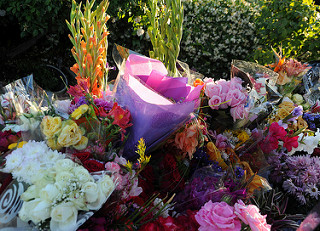

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

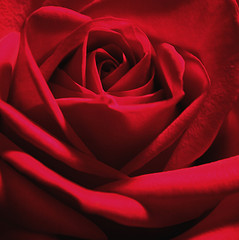

In [6]:
PIL.Image.open(str(roses[1]))

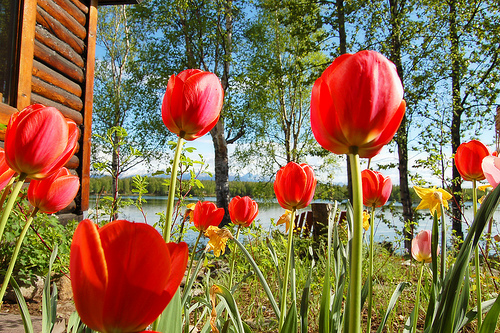

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

In [8]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2021-09-15 13:48:49.292295: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47220 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:67:00.0, compute capability: 7.5
2021-09-15 13:48:49.293780: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46822 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:68:00.0, compute capability: 7.5


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


# Explore the datasets

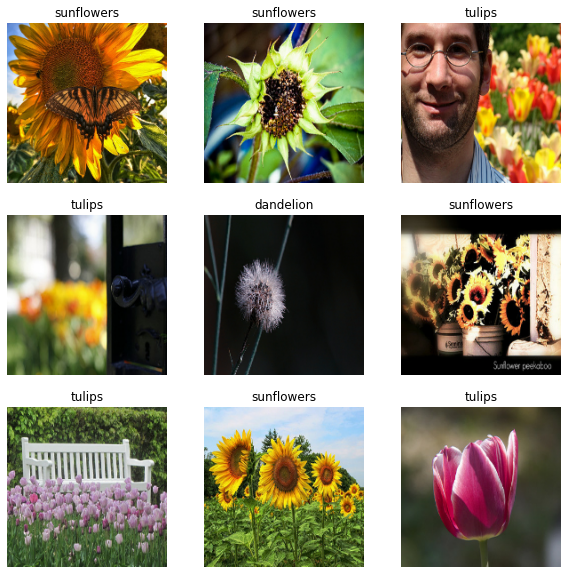

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## configure the dataset for performance

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

In [17]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0059910296 0.99424833


# create the model

In [18]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D  (None, 90, 90, 16)        0         
)                                                                
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)        0         
2D)                                                              
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        1

# train the model 

In [21]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


2021-09-15 13:53:28.151928: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


92/92 [==============================] - 4s 17ms/step - loss: 1.3713 - accuracy: 0.4183 - val_loss: 1.0860 - val_accuracy: 0.5477
Epoch 2/10
92/92 [==============================] - 1s 13ms/step - loss: 0.9571 - accuracy: 0.6247 - val_loss: 0.9829 - val_accuracy: 0.5995
Epoch 3/10
92/92 [==============================] - 1s 14ms/step - loss: 0.7437 - accuracy: 0.7149 - val_loss: 0.9696 - val_accuracy: 0.6240
Epoch 4/10
92/92 [==============================] - 1s 14ms/step - loss: 0.4973 - accuracy: 0.8225 - val_loss: 1.0524 - val_accuracy: 0.6376
Epoch 5/10
92/92 [==============================] - 1s 14ms/step - loss: 0.2956 - accuracy: 0.9043 - val_loss: 1.2188 - val_accuracy: 0.6199
Epoch 6/10
92/92 [==============================] - 1s 13ms/step - loss: 0.1527 - accuracy: 0.9513 - val_loss: 1.4863 - val_accuracy: 0.6471
Epoch 7/10
92/92 [==============================] - 1s 13ms/step - loss: 0.1229 - accuracy: 0.9659 - val_loss: 1.5634 - val_accuracy: 0.6281
Epoch 8/10
92/92 [======

# Visualize the result

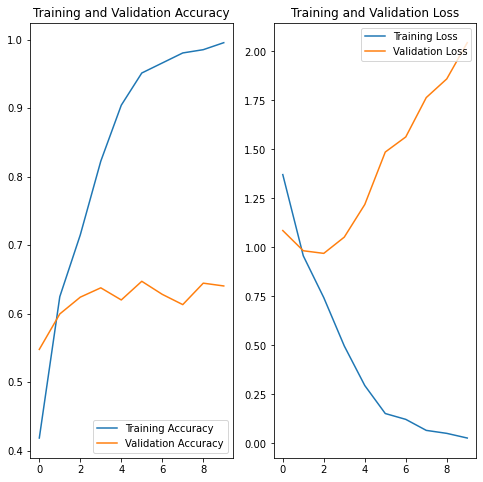

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# overfitting

## Data augmentation

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

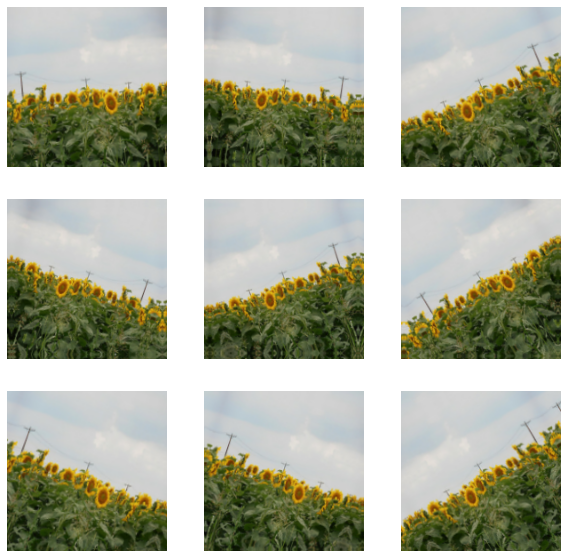

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [25]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)        0         
2D)                                                              
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)        0         
2D)                                                   

In [28]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 2s 17ms/step - loss: 1.3732 - accuracy: 0.4077 - val_loss: 1.0951 - val_accuracy: 0.5327
Epoch 2/15
92/92 [==============================] - 1s 16ms/step - loss: 1.0729 - accuracy: 0.5705 - val_loss: 0.9981 - val_accuracy: 0.6035
Epoch 3/15
92/92 [==============================] - 1s 16ms/step - loss: 0.9476 - accuracy: 0.6339 - val_loss: 0.9145 - val_accuracy: 0.6431
Epoch 4/15
92/92 [==============================] - 1s 16ms/step - loss: 0.8844 - accuracy: 0.6614 - val_loss: 0.8531 - val_accuracy: 0.6730
Epoch 5/15
92/92 [==============================] - 1s 15ms/step - loss: 0.8100 - accuracy: 0.6890 - val_loss: 0.8762 - val_accuracy: 0.6812
Epoch 6/15
92/92 [==============================] - 1s 15ms/step - loss: 0.7608 - accuracy: 0.7119 - val_loss: 0.7661 - val_accuracy: 0.7125
Epoch 7/15
92/92 [==============================] - 1s 15ms/step - loss: 0.7315 - accuracy: 0.7159 - val_loss: 0.8626 - val_accuracy: 0.6621
Epoch 8/15
92

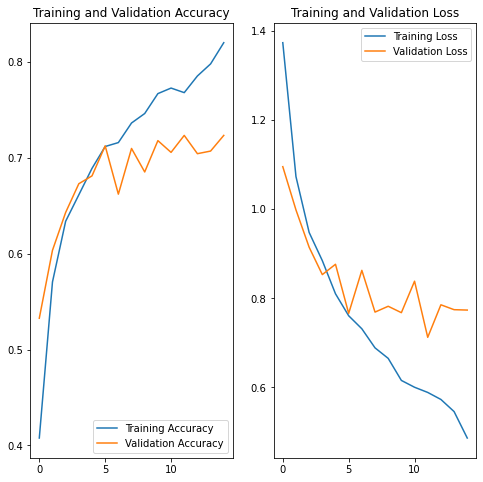

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Dropout

In [31]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [33]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)        0         
2D)                                                              
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)        0         
g2D)                                                  

In [34]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 2s 17ms/step - loss: 1.2166 - accuracy: 0.4758 - val_loss: 1.0419 - val_accuracy: 0.5790
Epoch 2/15
92/92 [==============================] - 1s 15ms/step - loss: 1.0273 - accuracy: 0.5974 - val_loss: 0.9542 - val_accuracy: 0.6226
Epoch 3/15
92/92 [==============================] - 1s 15ms/step - loss: 0.9470 - accuracy: 0.6287 - val_loss: 0.9384 - val_accuracy: 0.6390
Epoch 4/15
92/92 [==============================] - 1s 15ms/step - loss: 0.8530 - accuracy: 0.6659 - val_loss: 0.8884 - val_accuracy: 0.6635
Epoch 5/15
92/92 [==============================] - 1s 15ms/step - loss: 0.8045 - accuracy: 0.6941 - val_loss: 0.8067 - val_accuracy: 0.6853
Epoch 6/15
92/92 [==============================] - 1s 15ms/step - loss: 0.7608 - accuracy: 0.7071 - val_loss: 0.7724 - val_accuracy: 0.7016
Epoch 7/15
92/92 [==============================] - 1s 15ms/step - loss: 0.7154 - accuracy: 0.7296 - val_loss: 0.7909 - val_accuracy: 0.6866
Epoch 8/15
92

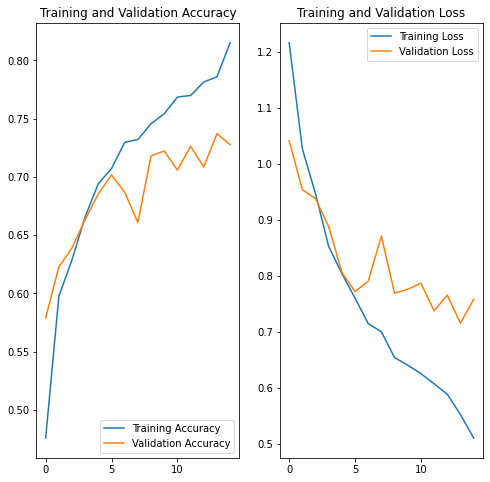

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()